In [1]:
from nilearn.connectome import ConnectivityMeasure
from brainspace.utils.parcellation import reduce_by_labels
import numpy as np
import os.path as op
from numrisk.fmri_analysis.gradients.utils import cleanTS, get_glasser_parcels
import seaborn as sns
import pandas as pd
import os
import nilearn.plotting as nplt
import matplotlib.pyplot as plt

bids_folder = '/mnt_03/ds-dnumrisk' 
plot_folder = os.path.join(bids_folder, 'plots_and_ims/glm_conn_ppi')
os.makedirs(plot_folder) if not op.exists(plot_folder) else None

# group list
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')

# Get Glasser parcellation and mask
from numrisk.fmri_analysis.gradients.utils import get_glasser_CAatlas_mapping, get_glasser_parcels
glasser_CAatlas_mapping, CAatlas_names = get_glasser_CAatlas_mapping()
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )

from brainspace.utils.parcellation import map_to_labels
from nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage()

from utils_01 import get_cleanTS_run, get_events_confounds
import statsmodels.api as sm

In [2]:
N_parcels = 360
right_parcel_n = 275
left_parcel_analog = right_parcel_n - 180
left_parcel_analog

95

In [3]:
# seed parcel is number
seed_parcel_n = 275 # 230 275 297, left homolog: 95
seed_parcel = seed_parcel_n - 1

In [4]:
# seed (parcel) is ind.nPRFs
thresh = 0.05
hemi = 'both'
seed_parcel_n = f'indnPRFs_hemi-{hemi}_thresh-{thresh}'

from utils_01 import get_NPC_mask
from numrisk.neural_general.utils import get_nPRFs_params

In [5]:
psy_context1 = 'stimulus1_int'
psy_context2 = 'stimulus2_int'
regressors_names = ['seedTS', 'psy_context1', 'psy_context2', 'seedTS:psy_context1', 'seedTS:psy_context2']
formula = 'targetTS ~ ' + ' + '.join(regressors_names)

## Run 1st level models
prep data and save DF


In [ ]:
# Run 1st level models

beta_maps = []
tval_maps = []
for subject in range(1, 67):
    sub = f'{int(subject):02d}'
    # prep data
    DMs = []
    TSs = []
    for run in range(1, 7):
        try:
            dm = get_events_confounds(sub, ses=1, run=run, bids_folder=bids_folder)
            dm['run'] = run
            ts = get_cleanTS_run(sub, run=run, bids_folder=bids_folder)

            TSs.append(ts)
            DMs.append(dm)
        except:
            print(f'!!! ------ problems for run {run} (sub {sub} )')
    dm = pd.concat(DMs) # 1128 timesteps = 188 x 6
    dm.index.name = 'onset'
    dm.set_index('run',append=True,inplace=True)

    TSs = np.array(TSs)
    TSs = TSs.transpose(1, 0, 2).reshape(TSs.shape[1], (TSs.shape[0]*TSs.shape[2])) # concatenate runs
    clean_ts = reduce_by_labels(TSs[mask_glasser], labeling_glasser[mask_glasser], axis=1, red_op='mean',dtype=float)

    # define seedTS
    if type(seed_parcel_n) == int:
        seedTS = clean_ts[seed_parcel]
    else:
        try:
            mask_NPC = get_NPC_mask(bids_folder=bids_folder, hemi='both')
            params_NPC = get_nPRFs_params(sub, bids_folder=bids_folder)
            mask_individual_npc = (params_NPC > thresh)
            mask_individual_npc[~mask_NPC] = False
            seedTS = np.mean(TSs[mask_individual_npc], axis=0)
            if np.sum(mask_individual_npc) < 5 :
                print(f'!!! ------ limited N-vertices for ind. NPC mask for sub {sub}, using parcel {seed_parcel} ')
                seedTS = clean_ts[seed_parcel]
            else:
                print(f'ind. NPC mask for sub {sub} created with {np.sum(mask_individual_npc)} vertices')

        except:
            seedTS = clean_ts[seed_parcel]
            print(f'!!! ------ problems with ind. NPC mask for sub {sub}, using parcel {seed_parcel} ')
    #Fit model
    coef = {param: [] for param in regressors_names}
    tvals = {param: [] for param in regressors_names}
    for parcel_n in range(360):
        df_glm = pd.DataFrame(np.array([seedTS, clean_ts[parcel_n], dm[psy_context1], dm[psy_context2]]).T, columns = ['seedTS','targetTS','psy_context1', 'psy_context2'])
        result = sm.formula.ols(formula=formula, data=df_glm).fit()
        [tvals[param].append(result.tvalues[param]) for param in tvals.keys()]
        [coef[param].append(result.params[param]) for param in coef.keys()]

    beta_maps.append({key: np.array(value) for key, value in coef.items()})
    tval_maps.append({key: np.array(value) for key, value in tvals.items()})

# ~ 6 mins

In [6]:
# prep data 
data = []
for i in range(66):
    for param in regressors_names:
        data.append(tval_maps[i][param])

index = pd.MultiIndex.from_product([range(1, 67), regressors_names], names=['subject', 'regressor'])
df_params = pd.DataFrame(data, index=index, columns=[f'parcel_{i}' for i in range(1, 361)])
df = df_params.join(group_list).set_index('group',append=True)
df.to_csv(op.join(bids_folder, 'derivatives', 'ppi', f'ppi_Tvals-allSubsDF_seed-{seed_parcel_n}.csv'))


In [7]:
# prep data 
data = []
for i in range(66):
    for param in regressors_names:
        data.append(beta_maps[i][param])

index = pd.MultiIndex.from_product([range(1, 67), regressors_names], names=['subject', 'regressor'])
df_params = pd.DataFrame(data, index=index, columns=[f'parcel_{i}' for i in range(1, 361)])
df = df_params.join(group_list).set_index('group',append=True)
df.to_csv(op.join(bids_folder, 'derivatives', 'ppi', f'ppi_betas-allSubsDF_seed-{seed_parcel_n}.csv'))


## read in 1st level DFs

In [6]:
# read in DFs

stats_param = 'betas' # Tvals
thresh = 0.05
hemi = 'both'
seed_parcel_n = f'indnPRFs_hemi-{hemi}_thresh-{thresh}'

df = pd.read_csv(op.join(bids_folder, 'derivatives', 'ppi', f'ppi_{stats_param}-allSubsDF_seed-{seed_parcel_n}.csv'))
df.set_index(['subject','regressor','group'], inplace=True)
df.head()

parcel_1  parcel_2  parcel_3  parcel_4  \
subject regressor           group                                           
1       seedTS              0     -0.014957  0.168600 -0.018898 -0.003214   
        psy_context1        0     -0.059228  0.114101 -0.093043  0.007335   
        psy_context2        0     -0.123531  0.154777 -0.117143 -0.047022   
        seedTS:psy_context1 0     -0.003554  0.095438  0.121408 -0.005773   
        seedTS:psy_context2 0      0.175430  0.104285  0.335926  0.096731   

                                   parcel_5  parcel_6  parcel_7  parcel_8  \
subject regressor           group                                           
1       seedTS              0      0.054332  0.212653  0.179523 -0.018240   
        psy_context1        0     -0.037385  0.104315  0.091230 -0.086908   
        psy_context2        0     -0.102188 -0.007030 -0.036244 -0.060711   
        seedTS:psy_context1 0      0.064708  0.082105  0.027602 -0.020507   
        seedTS:psy_context2 0      0.125719  0.091732  0.018085  0.111281   

                                   parcel_9  parcel_10  ...  parcel_351  \
subject regressor           group                       ...               
1       seedTS              0     -0.017037   0.111005  ...   -0.054316   
        psy_context1        0     -0.086319  -0.014850  ...    0.022358   
        psy_context2        0      0.079197  -0.106330  ...    0.084267   
        seedTS:psy_context1 0      0.003837  -0.023630  ...    0.014654   
        seedTS:psy_context2 0      0.141993  -0.010449  ...   -0.012492   

                                   parcel_352  parcel_353  parcel_354  \
subject regressor           group                                       
1       seedTS              0        0.010490    0.001793    0.046336   
        psy_context1        0        0.011689   -0.006296   -0.109386   
        psy_context2        0        0.098189   -0.043350   -0.039197   
        seedTS:psy_context1 0       -0.028024   -0.058104   -0.116976   
        seedTS:psy_context2 0       -0.084600   -0.066965   -0.131865   

                                   parcel_355  parcel_356  parcel_357  \
subject regressor           group                                       
1       seedTS              0       -0.045360   -0.295949   -0.184227   
        psy_context1        0       -0.123450    0.123258    0.131254   
        psy_context2        0       -0.110651   -0.024948    0.087602   
        seedTS:psy_context1 0       -0.076077    0.035983   -0.120419   
        seedTS:psy_context2 0        0.031170   -0.007062   -0.087343   

                                   parcel_358  parcel_359  parcel_360  
subject regressor           group                                      
1       seedTS              0       -0.077299    0.041824   -0.212453  
        psy_context1        0       -0.125209    0.093687    0.076827  
        psy_context2        0       -0.097826    0.260001    0.093343  
        seedTS:psy_context1 0        0.165920    0.072593    0.058692  
        seedTS:psy_context2 0        0.064019    0.137774    0.096272  

[5 rows x 360 columns]

In [7]:
tstat_cmap = 'bwr'
views = ['medial','lateral','dorsal','posterior']


# one sample TTest

In [ ]:
# one sample TTest
from scipy.stats import ttest_1samp

for param in regressors_names:
    tmp = df.xs(param,0,'regressor')
    t_stats, p_values = ttest_1samp(tmp, popmean=0, axis=0)

    stats_fsav5 = map_to_labels(t_stats, labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
    p_values_fsav5 = map_to_labels(p_values, labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
    stats_fsav5[p_values_fsav5 > 0.05] = np.nan

    figure, axes = plt.subplots(nrows=2, ncols=len(views),figsize = (15,10), subplot_kw=dict(projection='3d'))

    for j, hemi in enumerate(['L','R']):
        map = np.split(stats_fsav5,2)[j]
        surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
        bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left
        Tval_extrem = np.max(np.abs(np.nan_to_num(stats_fsav5, nan=0.0, posinf=0.0, neginf=0.0)))
        for i,view in enumerate(views):
            colbar = True if view == 'posterior' and hemi == 'R' else False
            nplt.plot_surf(surf_mesh=surf_mesh , surf_map= map, vmin=-Tval_extrem, vmax=Tval_extrem,
                    view= view,cmap=tstat_cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                    bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[j,i]) 

    figure.subplots_adjust(wspace=0.01, hspace=0.01)
    figure.suptitle(f'PPI - {param}, \n one sample T-stats \n seedParcel-{seed_parcel_n}', y=0.85) # for p-val < 0.05
    #plt.savefig(os.path.join(plot_folder, f'ppi_{param}_1sTstat_seedParcel-{seed_parcel_n}.png'), bbox_inches='tight', pad_inches=0.1)
#figure.tight_layout()



# 2 sample TTest

In [ ]:
# 2 sample TTest
from scipy.stats import ttest_ind
correct_p_values = False

for param in regressors_names:
    tmp = df.xs(param,0,'regressor')
    group_0 = tmp.xs(0,0,'group')
    group_1 = tmp.xs(1,0,'group')

    t_stats, p_values = ttest_ind(group_0, group_1, axis=0, equal_var=False)    
    #p_values = multipletests(p_values, method='fdr_bh')[1] if correct_p_values else p_values
    name_spec = '_pvalFDRcorrected' if correct_p_values else ''

    stats_fsav5 = map_to_labels(t_stats, labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
    p_values_fsav5 = map_to_labels(p_values, labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
    stats_fsav5[p_values_fsav5 > 0.05] = np.nan

    figure, axes = plt.subplots(nrows=2, ncols=len(views),figsize = (15,10), subplot_kw=dict(projection='3d'))

    for j, hemi in enumerate(['L','R']):
        map = np.split(stats_fsav5,2)[j]
        surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
        bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left
        Tval_extrem = np.max(np.abs(np.nan_to_num(stats_fsav5, nan=0.0, posinf=0.0, neginf=0.0)))
        for i,view in enumerate(views):
            colbar = True if view == 'posterior' and hemi == 'R' else False
            nplt.plot_surf(surf_mesh=surf_mesh , surf_map= map, vmin=-Tval_extrem, vmax=Tval_extrem,
                    view= view,cmap=tstat_cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                    bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[j,i]) 

    figure.subplots_adjust(wspace=0.01, hspace=0.01)
    figure.suptitle(f'PPI - {param}, \n 2sampleT-stats (blue= larger for DD) \n seedParcel-{seed_parcel_n} {name_spec}', y=0.85) # for p-val < 0.05
    plt.savefig(os.path.join(plot_folder, f'ppi_{param}_2sTstat_seedParcel-{seed_parcel_n}{name_spec}.png'), bbox_inches='tight', pad_inches=0.1)
#figure.tight_layout()



In [19]:
# try multiple comparison correction

from statsmodels.stats.multitest import multipletests

print('FDR correction: Number of parcels surviving multiple comparison')
for param in regressors_names:
    #param = 'seedTS:psy_context1'
    tmp = df.xs(param,0,'regressor')
    group_0 = tmp.xs(0,0,'group')
    group_1 = tmp.xs(1,0,'group')

    t_stats, p_values = ttest_ind(group_0, group_1, axis=0, equal_var=False)    
    corr_p_values = multipletests(p_values, method='fdr_bh')[1] #if correct_p_values else p_values # np.nan_to_num(p_values, nan=1, posinf=1, neginf=1)
    name_spec = '_pvalFDRcorrected' if correct_p_values else ''

    print(f'{param}: N =  {np.sum(corr_p_values < 0.05)}')


FDR correction: Number of parcels surviving multiple comparison
seedTS: N =  0
psy_context1: N =  0
psy_context2: N =  0
seedTS:psy_context1: N =  0
seedTS:psy_context2: N =  0


## ROI analysis

In [17]:
CAatlas_names

,Network Name
Label Number,
1,Visual1
2,Visual2
3,Somatomotor
4,Cingulo-Opercular
5,Dorsal-attention
6,Language
7,Frontoparietal
8,Auditory
9,Default


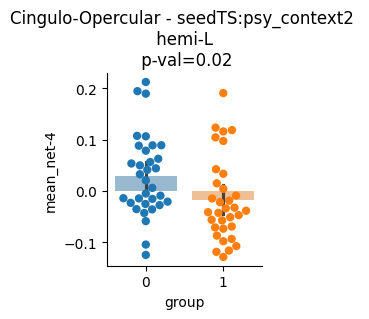

In [20]:
# get single p-vals for ROI analysis:
name_net = 'Cingulo-Opercular'#'Visual1'
n_net = np.where(CAatlas_names == name_net)[0][0] + 1
param = 'seedTS:psy_context2'

hemi =   'L' # 'both' #'R' #

parcel_numbers = [(i+1) for i in np.where(glasser_CAatlas_mapping == n_net)[0]]
if hemi == 'L':
    parcel_numbers = [i for i in parcel_numbers if i < 181]
elif hemi == 'R':
    parcel_numbers = [i for i in parcel_numbers if i > 180]

columns_to_keep = [f'parcel_{i}' for i in parcel_numbers]
tmp = df.xs(param,0,'regressor')
tmp = tmp.filter(items=columns_to_keep)
tmp = pd.DataFrame(tmp.mean(axis=1), columns=[f'mean_net-{n_net}'])
#tmp.head()
from scipy.stats import ttest_ind

y_var = f'mean_net-{n_net}'

figure, axes = plt.subplots(1, 1,figsize = (2,2.5))
sns.barplot(data=tmp.reset_index(), x ='group', hue='group',y=y_var, alpha=0.5,legend=False)
sns.swarmplot(data=tmp.reset_index(),  x ='group', hue='group',y=y_var, size=6,legend=False)
t_stats, p_values = ttest_ind(tmp.xs(0,0,'group')[y_var], tmp.xs(1,0,'group')[y_var], axis=0, equal_var=False)
p_val = np.round(p_values,3)

axes.set(title=f'{name_net} - {param} \n hemi-{hemi} \n p-val={p_val}',ylabel=y_var, xlabel='group')
sns.despine()


In [ ]:
# plot with corrected p-values (does not work if nothing survives)

stats_fsav5 = map_to_labels(t_stats, labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
p_values_fsav5 = map_to_labels(p_values, labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
stats_fsav5[corr_p_values > 0.05] = np.nan

figure, axes = plt.subplots(nrows=2, ncols=len(views),figsize = (15,10), subplot_kw=dict(projection='3d'))

for j, hemi in enumerate(['L','R']):
    map = np.split(stats_fsav5,2)[j]
    surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
    bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left
    Tval_extrem = np.max(np.abs(np.nan_to_num(stats_fsav5, nan=0.0, posinf=0.0, neginf=0.0)))
    for i,view in enumerate(views):
        colbar = True if view == 'posterior' and hemi == 'R' else False
        nplt.plot_surf(surf_mesh=surf_mesh , surf_map= map, vmin=-Tval_extrem, vmax=Tval_extrem,
                view= view,cmap=tstat_cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[j,i]) 

figure.subplots_adjust(wspace=0.01, hspace=0.01)
figure.suptitle(f'PPI - {param}, \n 2sampleT-stats (blue= larger for DD) \n seedParcel-{seed_parcel_n} {name_spec}', y=0.85) # for p-val < 0.05
plt.savefig(os.path.join(plot_folder, f'ppi_{param}_2sTstat_seedParcel-{seed_parcel_n}{name_spec}.png'), bbox_inches='tight', pad_inches=0.1)


In [21]:
# Close all figures
plt.close('all')

# Crop images

In [78]:
# Crop images

from PIL import Image
for stat_spec in ['2sTstat']: # 1sTstat', 
    for param in regressors_names:
        image = Image.open(os.path.join(plot_folder, f'ppi_{param}_{stat_spec}_seedParcel-{seed_parcel_n}.png'))
        image = image.convert("RGBA") # Convert to RGBA if not already in that mode

        width, height = image.size
        top = int(height // 2.5)
        bottom = int(2 * height // 3.5)

        # Create a new image without the specified rectangle
        new_image = Image.new("RGBA", (width, height - (bottom - top)))
        new_image.paste(image.crop((0, 0, width, top)), (0, 0)) # Paste the top part of the original image
        new_image.paste(image.crop((0, bottom, width, height)), (0, top)) # Paste the bottom part of the original image

        #plt.imshow(new_image)
        new_image.save(os.path.join(plot_folder, f'ppi_{param}_{stat_spec}_seedParcel-{seed_parcel_n}.png'))
